In [1]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, UpSampling2D, Input, LayerNormalization,Activation,Concatenate
from tensorflow.keras.layers import Layer,Add
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from models.skipnet import *
from utils.common import *
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import scipy.io as sio
from skimage.transform import rescale, pyramid_reduce
# from skimage.metrics import structural_similarity as ssim
import h5py

In [2]:
filepath1='./data/vietnam.mat'
data=sio.loadmat(filepath1)

Y20 = data['y20'].astype(np.float32)
Y10 = data['y10'].astype(np.float32)
Y60 = data['y60'].astype(np.float32)
scale = np.max([np.max(Y20),np.max(Y10),np.max(Y60)])
Y20u=rescale(Y20, scale = 2, multichannel = True)
Y60u=rescale(Y60, scale = 6, multichannel = True)
(y10,y20,y60,y20u,y60u)=(Y10,Y20,Y60,Y20u,Y60u)/scale

X20t=y20[tf.newaxis,:,:,:]
X10t=y10[tf.newaxis,:,:,:]
X60t=y60[tf.newaxis,:,:,:]

/home/han/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.


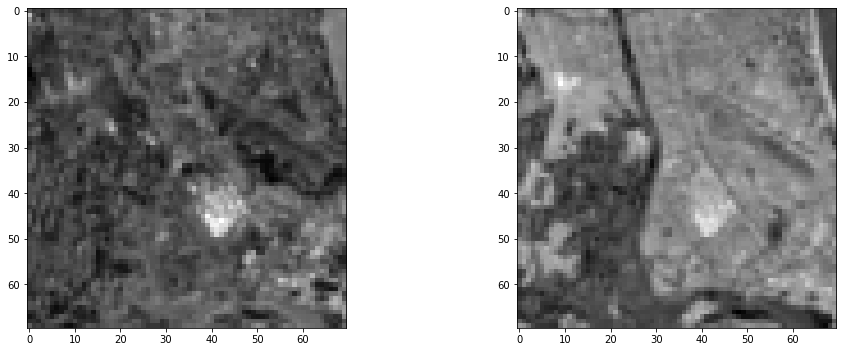

In [3]:
fig1=plt.figure(figsize=(15,5))
plt.subplot(121)             
plt.imshow(y60[:,:,0],cmap='gray')
plt.subplot(122)
plt.imshow(y60[:,:,1],cmap='gray')
plt.tight_layout()
plt.show()

In [4]:
b20 = Y20.shape[-1]
b60 = Y60.shape[-1]
b10 = Y10.shape[-1]
outchannel = 12
input_20 = Input((None,None,b20))
input_60 = Input((None,None,b60))
input_10 = Input((None,None,b10))

In [5]:
n=3
#begin first net
out=convbn(input_60,128)
up60 = UpSampling2D(size=(3,3),interpolation='bilinear')(out)
out=convbn(input_20,128)
out = convbn(Add()([out,up60]),128)
out20=input_20
skip=[]
for i in range(n):
    out20=convbn(input_20,128)
    out=convbn(Add()([out,out20]),128)
    skip.append(out20)
skip.reverse()
for i in range(n):
    if i==0:
        out = convbn(out,128)
    else:
        out20=convbn(Add()([out20,skip[i]]),128)
        out=convbn(Add()([out,out20]),128)

out=UpSampling2D(size=(2,2),interpolation='bilinear')(out)
out20_2=convbn(UpSampling2D(size=(2,2),interpolation='bilinear')(input_20),128)
out10=convbn(input_10,128)
out=convbn(Add()([out,out10,out20_2]),128)
out10=input_10
skips=[]
for i in range(2): 
    out10=convbn(out10,128)
    out=convbn(Add()([out,out10]),128)  
    skips.append(out10)
# skips.reverse()
# for i in range(2):
#     if i==0:
#         out = convbn(out,128)
#     else:
#         out10=convbn(Add()([out10,skips[i]]),128)
#         out=convbn(Add()([out,out10]),128)  

out = Conv2D(12,1,activation='sigmoid',padding='same')(out)
hr_model=Model([input_60,input_20,input_10],out)
out60=out[:,:,:,0:2]
out20=out[:,:,:,2:8]
out10=out[:,:,:,8:12]
# #Downsampling
down20=downsampler(factor=2,kernel='gaussian',band=20)(out20)
down60=downsampler(factor=6,kernel='gaussian',band=60)(out60)
sr_model=Model(inputs=[input_60,input_20,input_10],outputs=[down60,down20,out10])

In [6]:
opti = tf.keras.optimizers.Adam(learning_rate=0.001)
sr_model.compile(optimizer = opti, loss = 'mae')

In [7]:
fit_params = {
    'x': [X60t,X20t,X10t],
    'y': [X60t,X20t,X10t],
    'epochs': 10,
    'batch_size': 1,
    'verbose': 0,
}

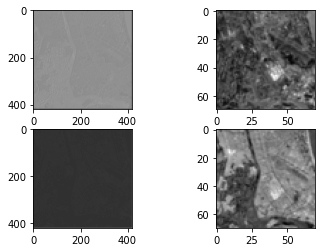

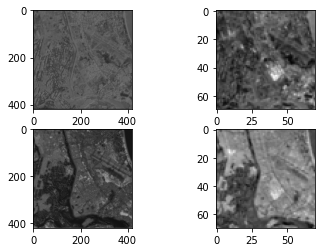

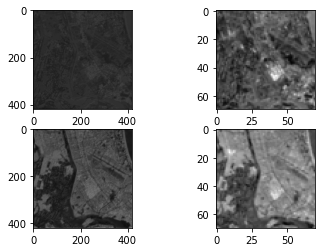

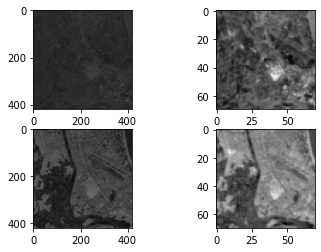

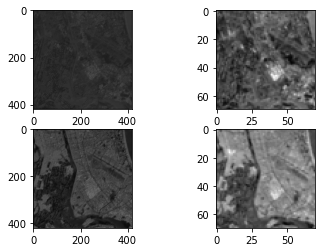

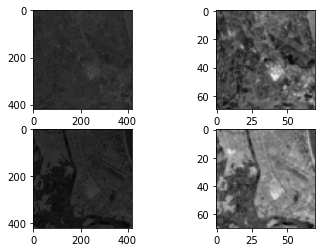

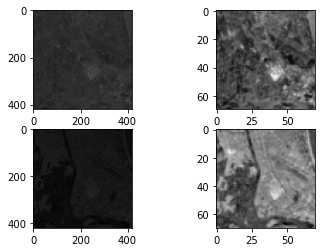

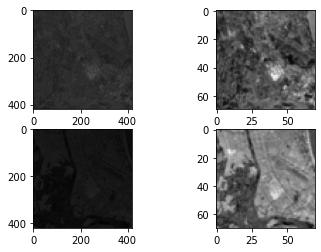

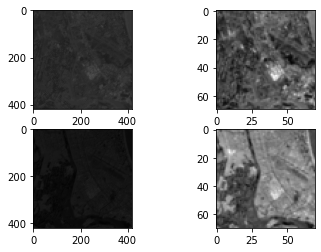

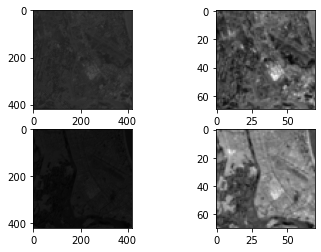

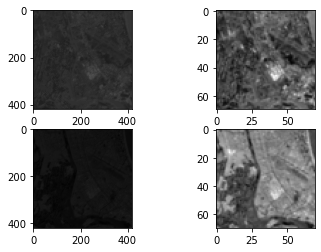

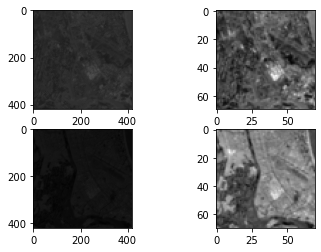

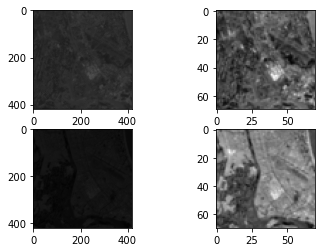

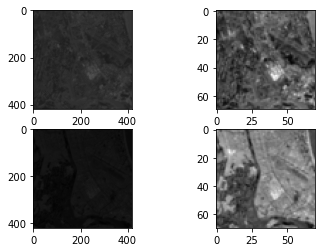

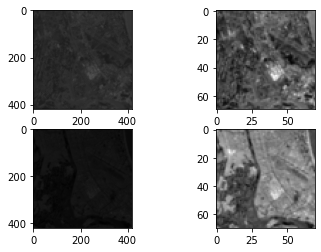

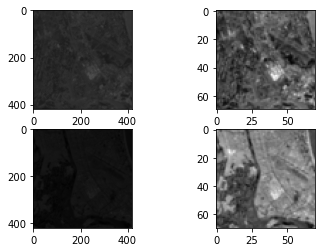

In [8]:
iteration=151;
cur_sre=0
totloss=[]
totsre=[]
for i in range(iteration):   
    h=sr_model.fit(**fit_params)
    img_hr_out = hr_model.predict([X60t,X20t,X10t], steps=1)[0]
    if (i%10)==0:
        plt.subplot(221)
        plt.imshow(img_hr_out[:,:,0],cmap='gray')
        plt.subplot(222)
        plt.imshow(y60[:,:,0],cmap='gray')
        plt.subplot(223)
        plt.imshow(img_hr_out[:,:,1],cmap='gray')
        plt.subplot(224)
        plt.imshow(y60[:,:,1],cmap='gray')
        plt.show()
    totloss.append(h.history['loss'][-1])

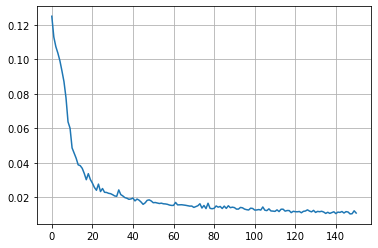

In [9]:
plt.plot(totloss)
plt.grid()
plt.show()

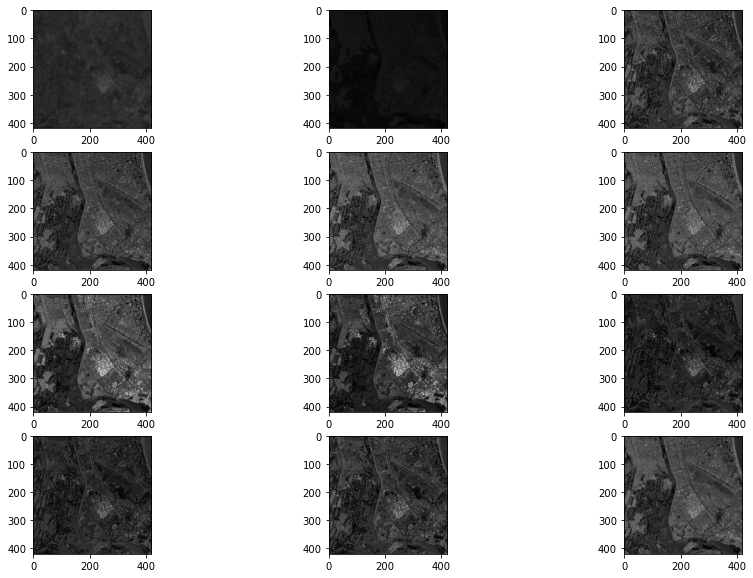

In [10]:
fig1=plt.figure(figsize=(15, 10))
columns = 3
rows = 4
for i in range(1, columns*rows +1):
    img = img_hr_out[:,:,i-1]
    fig1.add_subplot(rows, columns, i)
    plt.imshow(img,cmap='gray')
plt.show()


In [11]:
# sio.savemat('vietnam151.mat',mdict={'xout':img_hr_out*scale})